In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
!pwd
!ls

/content/drive/MyDrive
 AirQualityUCI1.csv	    go1220031104.fits
 air_quality_uci2.parquet   hotel_bookings_training.csv
 air_quality_uci3.parquet   inference_pipeline.joblib
 AirQualityUCI.csv	    new_customers.csv
'Colab Notebooks'	    __pycache__
 correlación.png	    transaction_dataset_clean.csv
 Data.csv		    transaction_dataset.csv
 Funciones.py		    videojuegos.csv
 go1020011213.fits


**Vamos a probar con un modelo clásico de ML**

**Modelo con Random Forest**

Librerías necesarias

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier                                             # El modelo de Random Forest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc             # Las métricas de evaluación
from sklearn.model_selection import train_test_split, RandomizedSearchCV                        # División en entrenamiento y testeo
import matplotlib.pyplot as plt

Cargamos el dataset limpio

In [6]:
df_RF = pd.read_csv('/content/drive/MyDrive/transaction_dataset_clean.csv')

df_RF

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 avg val sent,ERC20 uniq sent token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,30.000000,54.000000,0.00000,58.000000,0.000000,1.500000e+07,2.655861e+05,2.717799e+05,39.000000
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.000000,1.000000,5.000000,0.00000,7.000000,0.000000,3.650000e+02,5.763262e+01,2.260809e+00,1.000000
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000,7.000000,0.00000,8.000000,0.000000,4.428198e+02,6.518901e+01,0.000000e+00,0.000000
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.000000,2.000000,11.000000,0.00000,11.000000,0.000000,1.141223e+04,1.555550e+03,3.804077e+03,1.000000
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.000000,23.000000,0.00000,27.000000,0.000000,9.000000e+04,4.934232e+03,1.372666e+04,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,...,0.000000,0.000000,2.000000,0.00000,2.000000,0.000000,1.337000e+00,6.685000e-01,0.000000e+00,0.000000
9837,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,0.000000,0.000000,1.000000,0.00000,1.000000,13.370000,1.337000e+01,1.337000e+01,0.000000e+00,0.000000
9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,...,0.000000,0.000000,5.000000,0.00000,5.000000,0.000000,1.500000e+03,3.006939e+02,0.000000e+00,0.000000
9839,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,...,110.939207,5.638038,7.598535,0.00344,4.901909,485.614688,1.252524e+08,4.346203e+06,6.318389e+06,1.384931


**Preparación y división de los datos**

In [7]:
# Preparación de los datos
X = df_RF.drop('FLAG', axis=1)
y = df_RF['FLAG']

# División en entrenamiento (70%), validación (15%) y test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

**Normalización de los datos**

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**Entrenamiento inicial con parametros genéricos**

In [10]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

**Optimización de los hiperparámetros con el cojunto de validación**

In [11]:
# Definimos el modelo base
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': np.arange(50, 300, 50),  # Cantidad de árboles
    'max_depth': [None, 5, 10, 20, 30],      # Profundidad máxima
    'min_samples_split': [2, 5, 10],         # Mínimas muestras para dividir
    'min_samples_leaf': [1, 2, 4],           # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None]   # Cómo elegir las features en cada división
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,              # Número de combinaciones aleatorias que se van a probar
    cv=5,                   # Cross-validation con 5 folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_val, y_val)

mejores_params = random_search.best_params_
print("Mejores hiperparámetros encontrados:", mejores_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros encontrados: {'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


**Entrenamiento con los hiperparámetros óptimos**

In [12]:
rf_opt = RandomForestClassifier(**mejores_params, class_weight='balanced', random_state=42, n_jobs=-1)
rf_opt.fit(X_train, y_train)

# Métricas del conjunto de entrenamiento
y_train_pred = rf_opt.predict(X_train)
print("Matriz de confusión (Entrenaiento):\n", confusion_matrix(y_train, y_train_pred))
print("\nReporte de clasificación (Entrenamiento):\n", classification_report(y_train, y_train_pred))

Matriz de confusión (Entrenaiento):
 [[5363    0]
 [   0 1525]]

Reporte de clasificación (Entrenamiento):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5363
           1       1.00      1.00      1.00      1525

    accuracy                           1.00      6888
   macro avg       1.00      1.00      1.00      6888
weighted avg       1.00      1.00      1.00      6888



**Evaluación final con los datos de test**


Matriz de confusión (Test):
 [[1146    4]
 [  21  306]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1150
           1       0.99      0.94      0.96       327

    accuracy                           0.98      1477
   macro avg       0.98      0.97      0.97      1477
weighted avg       0.98      0.98      0.98      1477



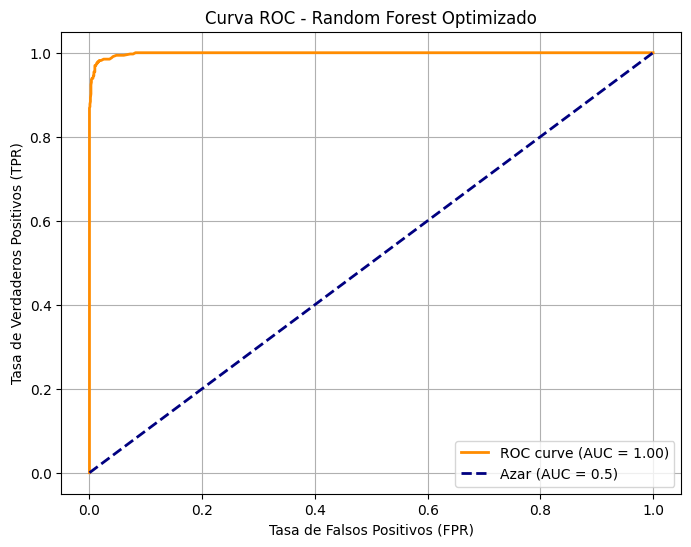

In [13]:
y_test_pred = rf_opt.predict(X_test)
print("\nMatriz de confusión (Test):\n", confusion_matrix(y_test, y_test_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_test_pred))

# Curva ROC y AUC
y_test_proba = rf_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest Optimizado')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Los resultados con Random Forest fueron sorprendentes, resultaron ser mejores que los de la red, incluso no hubo que aplicar oversampling para alcanzar estos resultados.

Matriz de confusión:

 [[1146   4]

 [  21  306]]

Reporte de clasificación:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1150
           1       0.99      0.94      0.96       327

    accuracy                           0.98      1477
   macro avg       0.98      0.97      0.97      1477

weighted avg       0.98      0.98      0.98      1477


**Análisis rápido**

**Clase 0 (mayoritaria):**

Precision: 0.98

Recall: 1.00

F1-score: 0.99

→ ¡Casi perfecto!

**Clase 1 (minoritaria):**

Precision: 0.98

Recall: 0.94

F1-score: 0.96

→ Muy buen recall (esto es clave en desbalance), y además sin bajar la precisión.

Accuracy general: 0.98

Pero lo más importante: no solo fue alta, sino balanceada en ambas clases.

**La curva ROC muestra un rendimiento casi perfecto**, con un AUC = 1.00, lo que significa que el modelo clasifica correctamente todas las instancias en el test. Esto indica que tiene una separación clara entre las clases y que no hay puntos de confusión entre fraudes y no fraudes.

Algo llamativo es que con random forest no es necesario normalizar, sin embargo si normalizo consigo un 0.94 en recall para fraude, caso contrario consigo 0.93